In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from synchrad.calc import SynchRad
from synchrad.utils import r_e, omega_1m, alpha_fs

from scipy.constants import e, m_e, c, epsilon_0, hbar
from scipy.integrate import solve_ivp

from axiprop.utils import get_temporal_radial, get_temporal_1d

from tqdm import tqdm

In [2]:
Np = 16000        # Number of electrons
Num_osc = 3       # Number of oscillations
K0 = 4.           # Undulator strength

# particles/beam central energy
particle_energy_MeV = 100

# Plasma density
n_p = 5e18 * 1e6

# Technical parameters : global

gamma_0 = particle_energy_MeV * 1e6 * e / (m_e * c**2)
pz0 = (gamma_0**2 - 1 -  K0**2)**.5

# Technical parameters: channel
omega_p = c * ( 4 * np.pi * r_e * n_p)**0.5 
omega_ch = omega_p / (2 * gamma_0)**0.5
lambda_ch = 2 * np.pi * c / omega_ch
omega_ch_und = 2 * gamma_0**2 * omega_ch  / (1 + K0**2)
omega_ch_crit = 3/2 * K0 * gamma_0**2 * omega_ch

# Simulation length and steps
L_ch =  Num_osc * lambda_ch
T_fin  = L_ch / c
Nt = L_ch / lambda_ch * 64

t_eval = np.r_[0: T_fin: 1j * Nt]
dt = t_eval[1] - t_eval[0]

In [3]:
# Spiral Beam

N_winds = 1.0
L_b = 0.4e-6
R_match = K0 * c/omega_p * (2/gamma_0)**0.5

energy_spread = 0.001
pr_spread = 0.0

#########################################################

z = np.linspace(0, L_b, Np)
if Np > 1:
    dz = z[1]-z[0]
    z = z + 0.5*dz*(np.random.rand(z.size)-0.5)

lam_z = L_b / N_winds
k_siprl = 2 * np.pi / lam_z

x = R_match * np.sin(k_siprl * z)
y = R_match * np.cos(k_siprl * z)

ux = - K0 * np.cos(k_siprl * z) * (1 + pr_spread * np.random.randn(Np))
uy = K0 * np.sin(k_siprl * z) * (1 + pr_spread * np.random.randn(Np))

uz = pz0 * (1 + energy_spread * np.random.randn(Np))

omega_VC = k_siprl * c

beta_phs = pz0 /gamma_0 + omega_ch/omega_VC
theta_vc = np.arccos(1./beta_phs)
theta_beta = K0/gamma_0

trak0 = np.array([x, y, z, ux, uy, uz])

In [4]:
def motion_channel(t, track, omega_p):
    x, y, z, ux, uy, uz = track
    
    gamma_p = np.sqrt(1.0 + ux**2 + uy**2 +  uz**2)
    
    dx = c * ux / gamma_p
    dy = c * uy / gamma_p
    dz = c * uz / gamma_p
    
    dux = - 0.5 * omega_p**2 / c * x
    duy = - 0.5 * omega_p**2 / c * y
    duz = 0.0
    
    return dx, dy, dz, dux, duy, duz

In [5]:
tracks = []

for ip in tqdm(range(Np)):
    x_, y_, z_, ux, uy, uz = solve_ivp( motion_channel, [0, T_fin], trak0[:, ip], 
                                        t_eval=t_eval, args=(omega_p,),
                                        method='Radau' ).y
    
    x, y, z, ux_, uy_, uz_ = solve_ivp( motion_channel, [0, T_fin+dt/2], trak0[:, ip], 
                                        t_eval=t_eval+dt/2, args=(omega_p,),
                                        method='Radau' ).y
    
    tracks.append([x, y, z, ux, uy, uz, 1.0, 0.0])

100%|██████████| 16000/16000 [04:34<00:00, 58.22it/s]


In [17]:
11e-6 / (theta_vc * 0.1 * L_ch), R_match*1e6, 2*(R_match +  0.1 * L_ch * theta_vc)*1e6

(2.6097391031497055, 0.9610127792312984, 10.351986995392481)

In [18]:
calc_input_far = {
    "grid": [
        (1e-3 * omega_VC/omega_1m, 30 * omega_VC / omega_1m),  
        (0, 1.2*theta_vc),
        (0, 2 * np.pi),
        (2048, 128, 1),
    ],  
}

calc_far = SynchRad(calc_input_far)
calc_far.calculate_spectrum( particleTracks=tracks,
                             comp='spheric_complex',
                             timeStep=c*dt )

L_screen = 1.1 * L_ch
Rmax = 12e-6
#Rmax = 2.5 * (R_match +  (L_screen - L_ch) * theta_vc)

calc_input_near = {
    "grid": [
        (1e-3*omega_VC/omega_1m, 30*omega_VC/omega_1m),  
        (0, Rmax),
        (0.0, 2 * np.pi),
        (2048, 256, 1),
    ],  
    "mode":"near"
}

calc_near = SynchRad(calc_input_near)
calc_near.calculate_spectrum( particleTracks=tracks,
                              comp='cartesian_complex',
                              L_screen=L_screen,
                              timeStep=c*dt )

Running on 1 devices
  ALL | GPU device: TITAN RTX
Platform: NVIDIA Corporation
Compiler: OpenCL C 1.2 
Separate it_range for each track will be used
Running on 1 devices
  ALL | GPU device: TITAN RTX
Platform: NVIDIA Corporation
Compiler: OpenCL C 1.2 
Separate it_range for each track will be used


In [19]:
print("Far Field")
print(f"\tW_r = {calc_far.get_energy(comp='r'):g}")
print(f"\tW_theta = {calc_far.get_energy(comp='theta'):g}")
print(f"\tW_phi = {calc_far.get_energy(comp='phi'):g}")

print("Near Field")
print(f"\tW_x = {calc_near.get_energy(comp='x'):g}")
print(f"\tW_y = {calc_near.get_energy(comp='y'):g}")
print(f"\tW_z = {calc_near.get_energy(comp='z'):g}")

Far Field
	W_r = 1.53673e-08
	W_theta = 3.01028e+06
	W_phi = 3.97355e+06
Near Field
	W_x = 770.961
	W_y = 440.882
	W_z = 35.1817


<IPython.core.display.Javascript object>


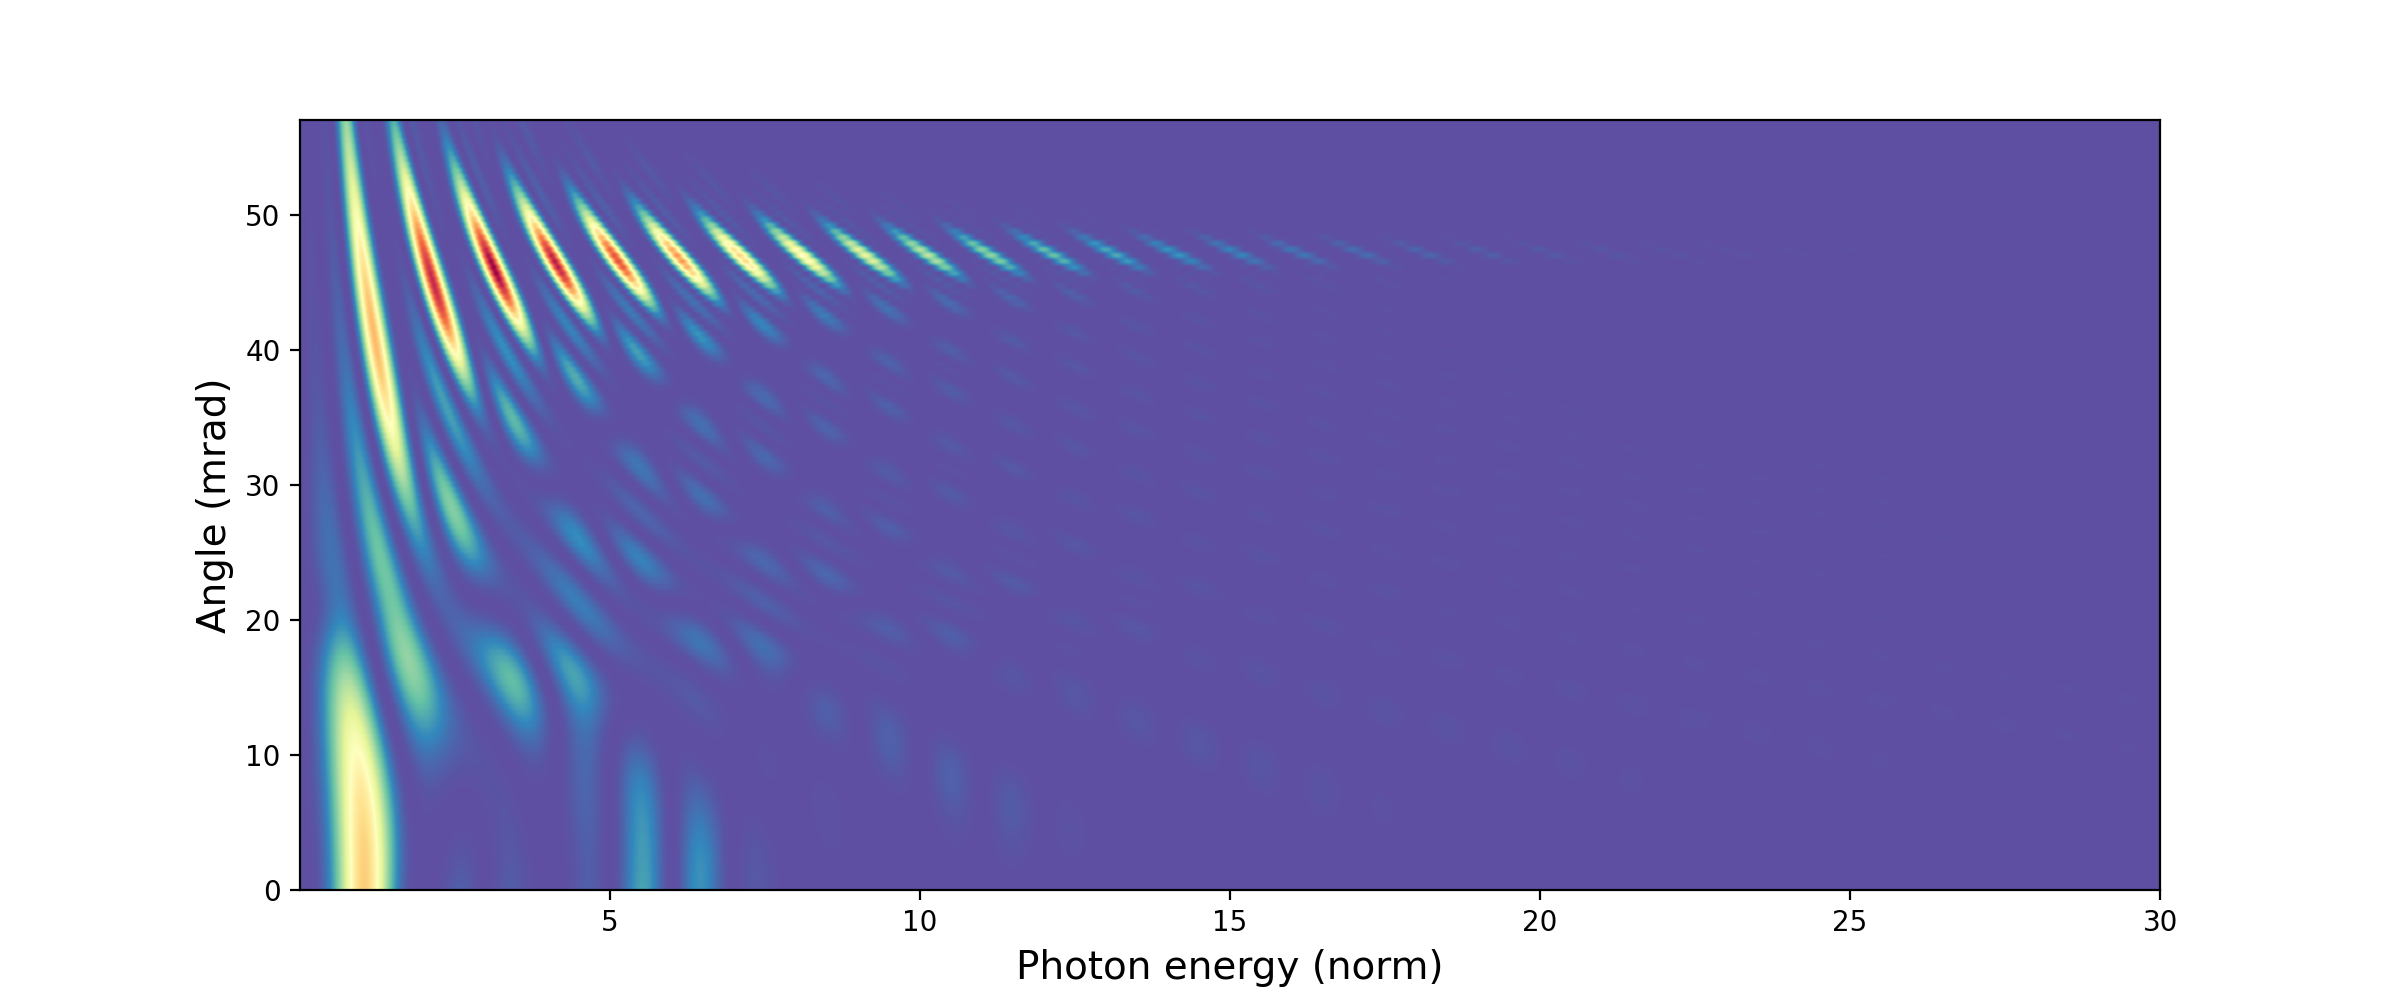

<IPython.core.display.Javascript object>


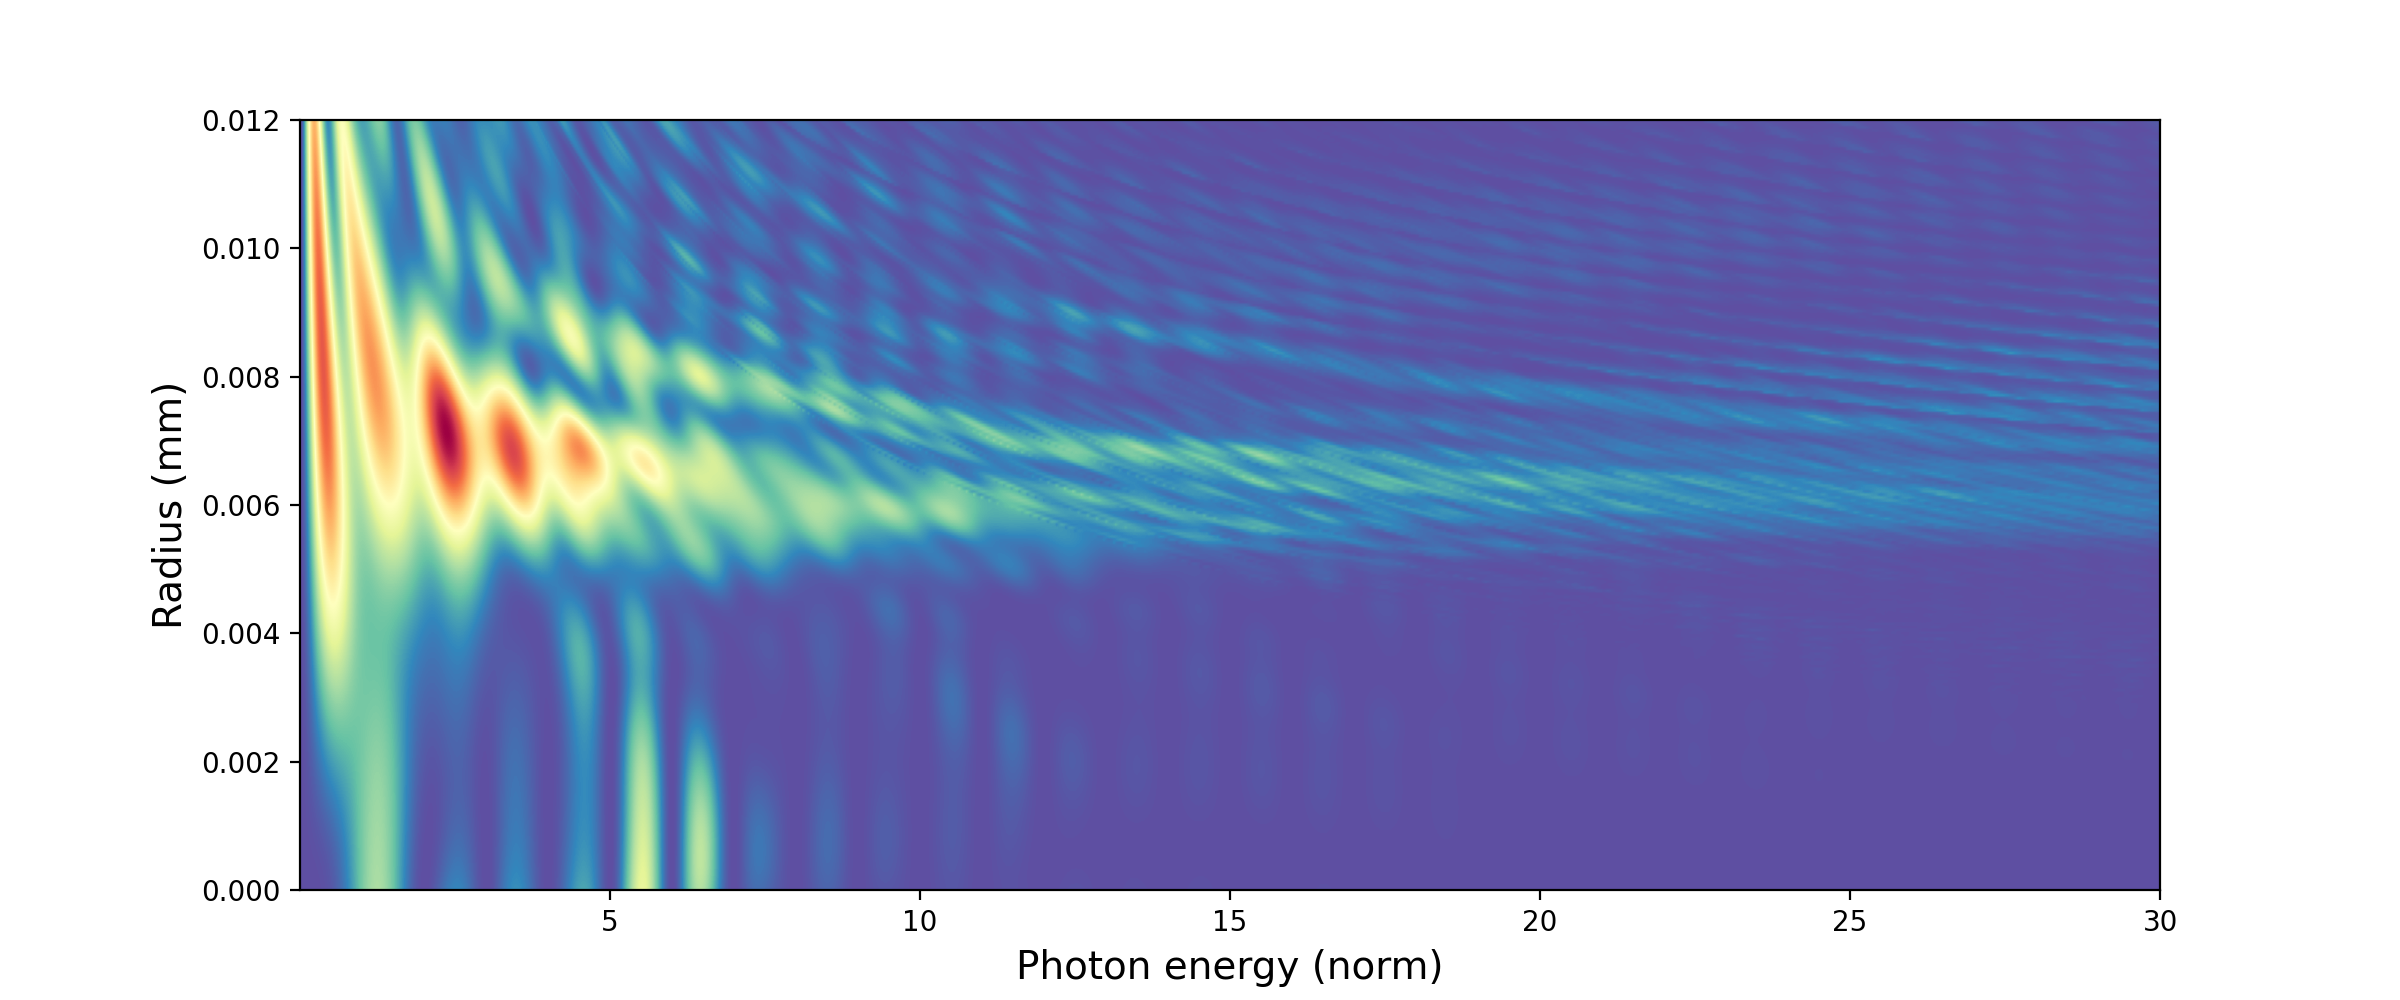

In [20]:
spect_ax = calc_far.get_spectral_axis() * omega_1m / (k_siprl * c)
spect_val = calc_far.get_full_spectrum()[:,:,0]

extent = [spect_ax.min(), 
          spect_ax.max(), 
          calc_far.Args['theta'].min()* 1e3,
          calc_far.Args['theta'].max()* 1e3 ]

plt.figure(figsize=(12,5))
plt.imshow( spect_val.T,
            extent = extent,
            cmap=plt.cm.Spectral_r,
            origin='lower', 
           aspect='auto' )
plt.xlabel('Photon energy (norm)', fontsize=14)
plt.ylabel('Angle (mrad)', fontsize=14);

##############################################################

spect_ax = calc_near.get_spectral_axis() * omega_1m / omega_VC
spect_val = calc_near.get_full_spectrum()[:,:,0]

extent = [spect_ax.min(), 
          spect_ax.max(), 
          calc_near.Args['radius'].min()* 1e3,
          calc_near.Args['radius'].max()* 1e3 ]

plt.figure(figsize=(12,5))
plt.imshow( spect_val.T,
            extent = extent,
            cmap=plt.cm.Spectral_r,
            origin='lower', 
           aspect='auto' )
plt.xlabel('Photon energy (norm)', fontsize=14)
plt.ylabel('Radius (mm)', fontsize=14);

<IPython.core.display.Javascript object>


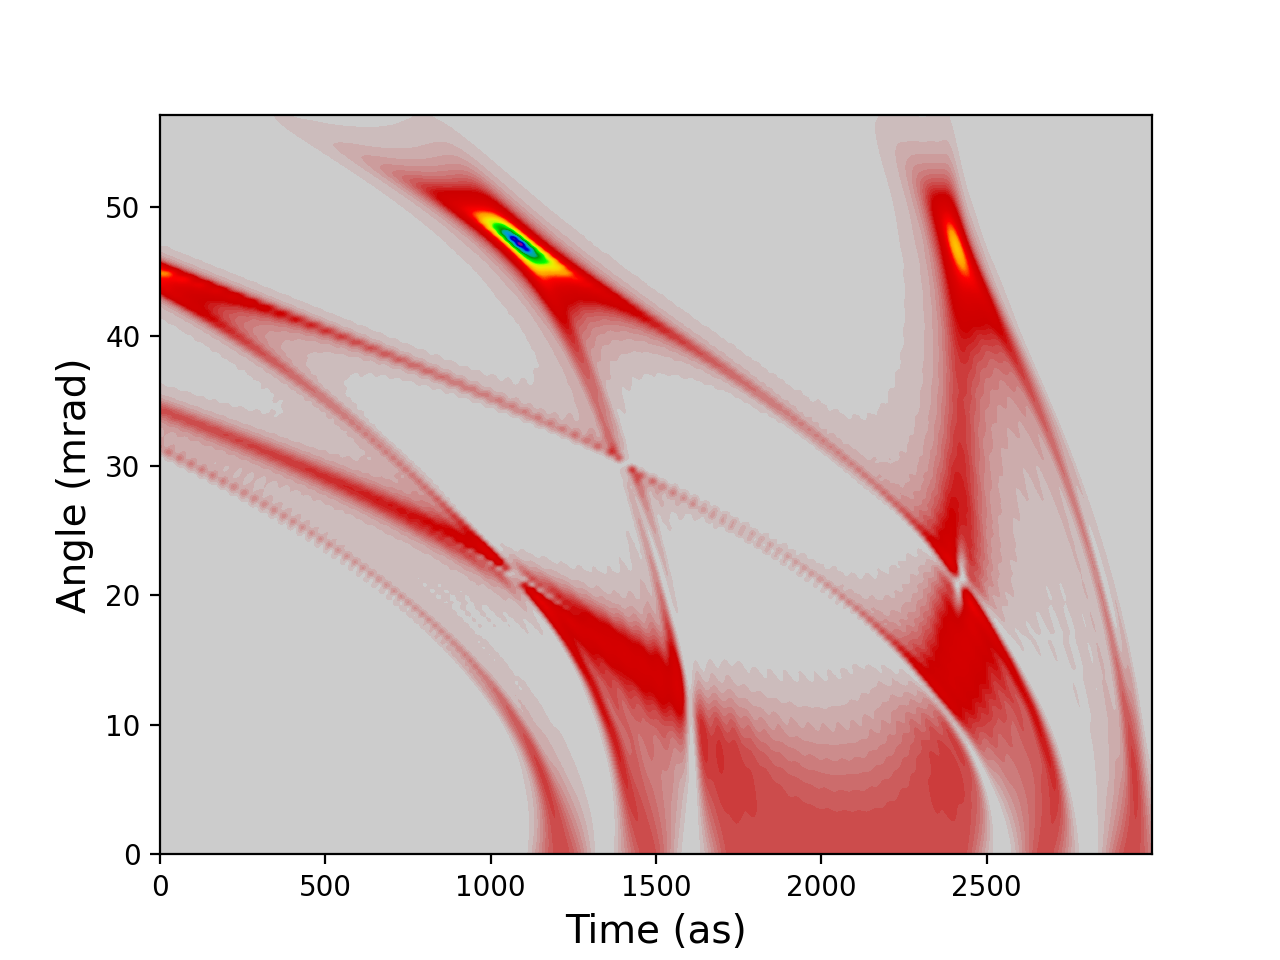

In [21]:
t_0 = 2*np.pi / (omega_VC)
dt_0 = 2e-4 * t_0
dt_window = 3e-15
tt = np.arange(0, dt_window, dt_0)
t_shift = 6e-15

k_z = calc_far.Args['omega']* omega_1m/c

E2 = 0.0

spect_val = calc_far.Data['radiation']['thetare'] + 1j * calc_far.Data['radiation']['thetaim']
Etr = np.zeros((tt.size, spect_val.shape[-2] ))
Etr =  get_temporal_radial(spect_val[0,:,:,0], Etr, tt+t_shift, k_z )
E2 += Etr**2

spect_val = calc_far.Data['radiation']['phire'] + 1j * calc_far.Data['radiation']['phiim']
Etr = np.zeros((tt.size, spect_val.shape[-2] ))
Etr =  get_temporal_radial(spect_val[0,:,:,0], Etr, tt+t_shift, k_z )
E2 += Etr**2

plt.figure()

vmax = 0.5 * E2.max()
ext = [tt.min() * 1e18,
       tt.max() * 1e18,
       calc_far.Args['theta'].min() * 1e3,
       calc_far.Args['theta'].max() * 1e3]

plt.imshow(E2.T, aspect='auto', origin='lower', 
           cmap=plt.cm.nipy_spectral_r, 
           extent=ext,
           interpolation='gaussian', 
           #vmax=vmax
          )

plt.xlabel('Time (as)', fontsize=14)
plt.ylabel('Angle (mrad)', fontsize=14);

In [25]:
2e-6/c * 1e15, 9e-6/c * 1e15

(6.671281903963041, 30.020768567833688)

<IPython.core.display.Javascript object>


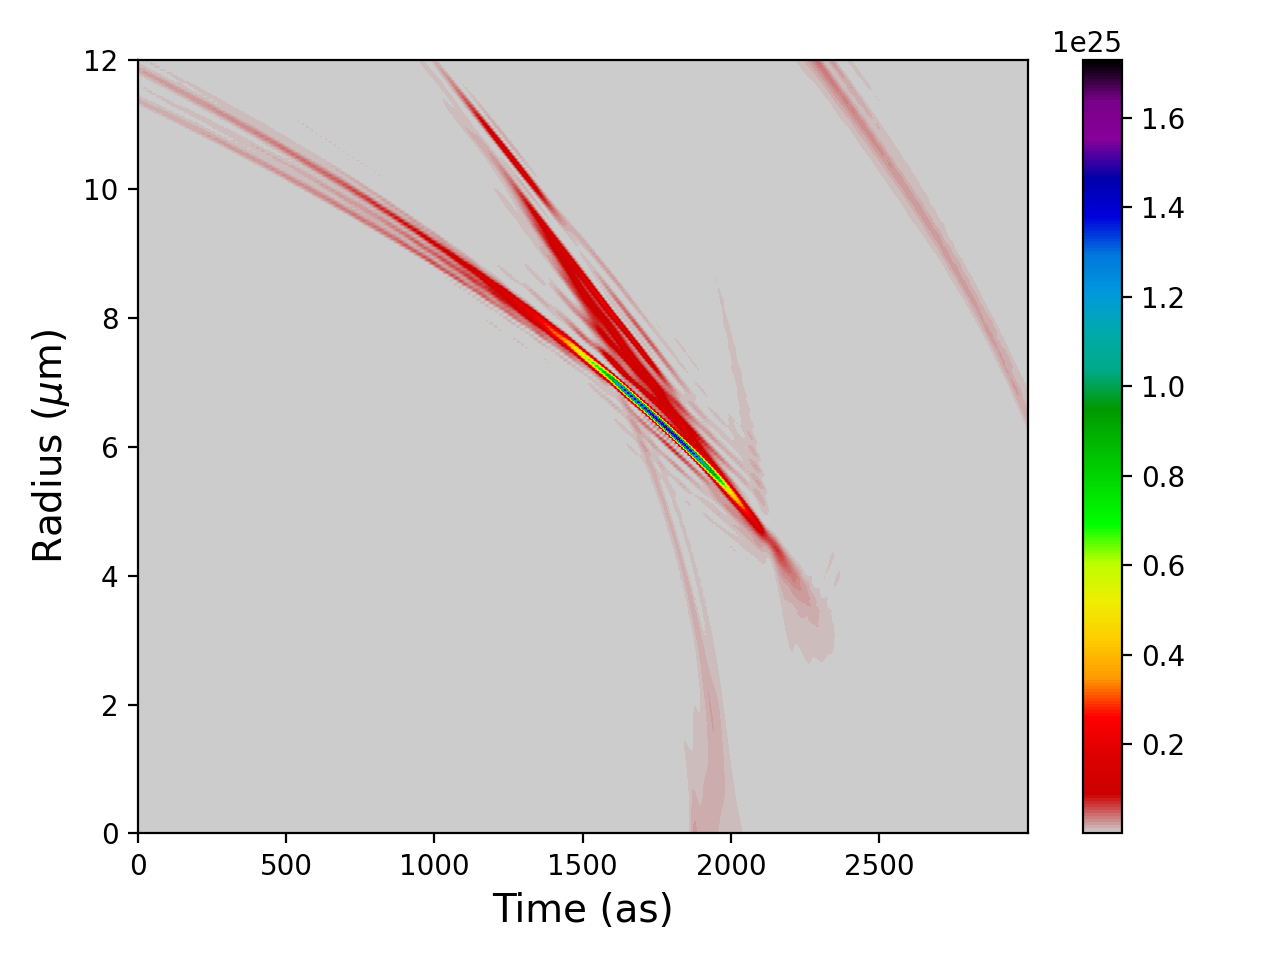

In [31]:
t_0 = 2*np.pi / (omega_VC)
k_z = calc_near.Args['omega']* omega_1m/c
dt_0 = 1e-4 * t_0
dt_window = 3e-15
tt = np.arange(0, dt_window, dt_0)
t_shift = 31e-15

E2 = 0.0

spect_val = calc_near.Data['radiation']['xre'] + 1j * calc_near.Data['radiation']['xim']
Etr = np.zeros((tt.size, spect_val.shape[-2] ))
Etr =  get_temporal_radial(spect_val[0,:,:,0], Etr, tt+t_shift, k_z )
E2 += Etr**2

spect_val = calc_near.Data['radiation']['yre'] + 1j * calc_near.Data['radiation']['yim']
Etr = np.zeros((tt.size, spect_val.shape[-2] ))
Etr =  get_temporal_radial(spect_val[0,:,:,0], Etr, tt+t_shift, k_z )
E2 += Etr**2

spect_val = calc_near.Data['radiation']['zre'] + 1j * calc_near.Data['radiation']['zim']
Etr = np.zeros((tt.size, spect_val.shape[-2] ))
Etr =  get_temporal_radial(spect_val[0,:,:,0], Etr, tt+t_shift, k_z )
E2 += Etr**2

plt.figure( tight_layout=True)

ext = [tt.min() * 1e18,
       tt.max()* 1e18,
       calc_near.Args['radius'].min() * 1e6,
       calc_near.Args['radius'].max() * 1e6]

plt.imshow(E2.T, 
           aspect='auto', 
           origin='lower', 
           cmap=plt.cm.nipy_spectral_r, 
           extent=ext,
          )

plt.colorbar()

plt.xlabel('Time (as)', fontsize=14)
plt.ylabel('Radius ($\mu$m)', fontsize=14);

In [29]:
np.array(plt.xlim()).ptp()

20.79568574979362